# Part 2: Twitter Data

 # Install cuDF & cuML
 Reference: https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0?usp=sharing

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

========================================

In [ ]:
# from matplotlib import path
from google.colab import drive
drive.mount('/content/drive')
import sys    
import os
path_to_module = '/content/drive/MyDrive/'
sys.path.append(path_to_module)
os.chdir(path_to_module)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Fri Mar 18 21:16:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
nltk.download("all")
import json
import datetime, time
import pytz
import csv
import math

import warnings
warnings.filterwarnings('ignore')

from nltk import pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words
from nltk.stem.lancaster import LancasterStemmer as LS

from string import punctuation
from collections import Counter
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score, f1_score

# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB

import cudf
import cuml

from cuml.preprocessing.text.stem import PorterStemmer
from cuml.feature_extraction.text import CountVectorizer
from cuml.feature_extraction.text import TfidfTransformer
from cuml.feature_extraction.text import TfidfVectorizer

from cuml.decomposition import TruncatedSVD

from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.ensemble import RandomForestRegressor as cuRFR
from cuml.svm import SVC

from cuml.naive_bayes import GaussianNB
from cuml.linear_model import LinearRegression
from cuml.linear_model import LogisticRegression

from cuml.metrics.regression import mean_squared_error
from cuml.metrics.regression import mean_absolute_error
from cuml.metrics.regression import r2_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [ ]:
tweetFiles = ["./ECE219_tweet_data/tweets_#superbowl.txt", 
              "./ECE219_tweet_data/tweets_#nfl.txt", 
              "./ECE219_tweet_data/tweets_#gohawks.txt", 
              "./ECE219_tweet_data/tweets_#gopatriots.txt", 
              "./ECE219_tweet_data/tweets_#patriots.txt", 
              "./ECE219_tweet_data/tweets_#sb49.txt"]

In [ ]:
# Explore and Test Key of Data
with open(tweetFiles[3], 'r', encoding="utf8") as file:
    first_line = file.readline()
    json_obj = json.loads(first_line)

    print('=' * 50)
    for key in json_obj:
        print(key)
    
    for key in json_obj:
        print('\n' + '-' * 50)
        print(key + ':')
        print(json_obj[key]) 

firstpost_date
title
url
tweet
author
original_author
citation_date
metrics
highlight
type
citation_url

--------------------------------------------------
firstpost_date:
1420835445

--------------------------------------------------
title:
LeGarrette Blount does the Ray Lewis Dance #ThrowbackThursday https://t.co/F5FX5KVmdX
Hope to see it at least 3 times tomorrow. 
#GoPatriots

--------------------------------------------------
url:
http://twitter.com/NESportsFan1106/status/553650101105606656

--------------------------------------------------
tweet:
{'contributors': None, 'truncated': False, 'text': 'LeGarrette Blount does the Ray Lewis Dance #ThrowbackThursday https://t.co/F5FX5KVmdX\nHope to see it at least 3 times tomorrow. \n#GoPatriots', 'in_reply_to_status_id': None, 'id': 553650101105606656, 'favorite_count': 0, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'retweeted': False, 'coordinates': None, 'timestamp_ms': '142083544

# Question 27

In [ ]:
max_time_seconds = {tweetFiles[0]: -1, 
                    tweetFiles[1]: -1, 
                    tweetFiles[2]: -1, 
                    tweetFiles[3]: -1, 
                    tweetFiles[4]: -1, 
                    tweetFiles[5]: -1}

min_time_seconds = {tweetFiles[0]: -1, 
                    tweetFiles[1]: -1, 
                    tweetFiles[2]: -1, 
                    tweetFiles[3]: -1, 
                    tweetFiles[4]: -1, 
                    tweetFiles[5]: -1}

In [ ]:
def report(tweetFile):
    with open(tweetFile, 'r', encoding="utf8") as file:
        lines = file.readlines()
    
    num_tweets = 0
    time_seconds, num_followers, num_retweets = [], [], []
    for line in lines:
        json_object = json.loads(line)
        num_tweets += 1
        time_seconds.append(json_object['citation_date'])
        num_followers.append(json_object['author']['followers'])
        num_retweets.append(json_object['metrics']['citations']['total'])
    
    max_time_seconds[tweetFile] = max(time_seconds)
    min_time_seconds[tweetFile] = min(time_seconds)

    print("Statistics of {}".format(tweetFile))
    print("Average number of tweets per hour: {}".format(num_tweets / ((max_time_seconds[tweetFile]-min_time_seconds[tweetFile]) / (60*60))))
    print("Average number of followers of users posting the tweets per tweet: {}".format(sum(num_followers) / num_tweets))
    print("Average number of retweets per tweet: {}".format(sum(num_retweets) / num_tweets))
    print('') 

In [ ]:
for tweetFile in tweetFiles:
    report(tweetFile)

Statistics of ./ECE219_tweet_data/tweets_#superbowl.txt
Average number of tweets per hour: 2072.11840170408
Average number of followers of users posting the tweets per tweet: 8814.96799424623
Average number of retweets per tweet: 2.3911895819207736

Statistics of ./ECE219_tweet_data/tweets_#nfl.txt
Average number of tweets per hour: 397.0213901819841
Average number of followers of users posting the tweets per tweet: 4662.37544523693
Average number of retweets per tweet: 1.5344602655543254

Statistics of ./ECE219_tweet_data/tweets_#gohawks.txt
Average number of tweets per hour: 292.48785062173687
Average number of followers of users posting the tweets per tweet: 2217.9237355281984
Average number of retweets per tweet: 2.0132093991319877

Statistics of ./ECE219_tweet_data/tweets_#gopatriots.txt
Average number of tweets per hour: 40.95469800606194
Average number of followers of users posting the tweets per tweet: 1427.2526051635405
Average number of retweets per tweet: 1.4081919101697078


# Question 28

In [ ]:
def plot_tweets_hour(tweetFile, title):
    with open(tweetFile, 'r', encoding="utf8") as file:
        lines = file.readlines()
    
    max_seconds = max_time_seconds[tweetFile]
    min_seconds = min_time_seconds[tweetFile]

    total_hours = int((max_seconds-min_seconds) / (60*60) + 1)
    x = range(total_hours)
    y = [0] * total_hours

    for line in lines:
        json_object = json.loads(line)
        y[int((json_object['citation_date']-min_seconds) / (60*60))] += 1

    plt.title("Number of Tweets in hours of " + title)
    plt.bar(x, y, 1)
    plt.xlabel("Hours over Time")
    plt.ylabel("Number of Tweets")
    plt.gcf().set_size_inches(10, 7)
    plt.show()

- #SuperBowl

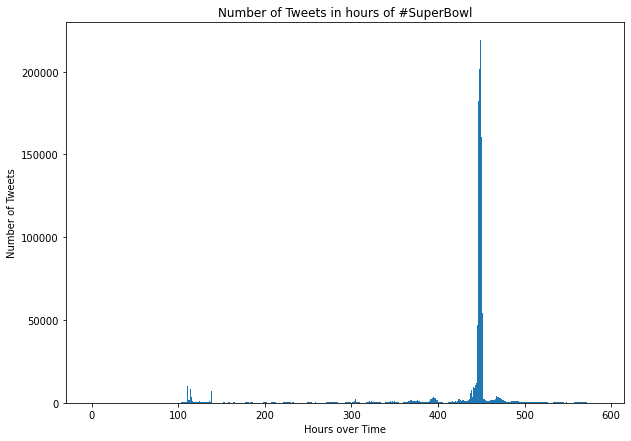

In [ ]:
plot_tweets_hour(tweetFiles[0], "#SuperBowl")

- #NFL

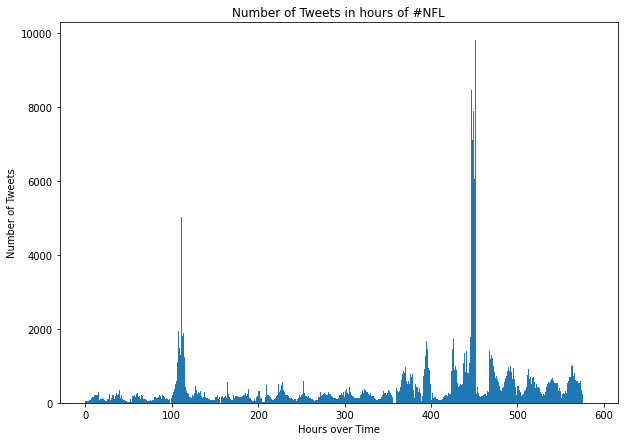

In [ ]:
plot_tweets_hour(tweetFiles[1], "#NFL")

# Question 29

- Describe out task: Library of Prediction Tasks given a tweet

1. Predict the hashtags. 
2. Predict the number of retweets.
3. Predict the number of likes.
4. Predict the number of quotes.
5. Predict the relative(UNIX) time when a tweet was posted.
6. Creativity - Predict the number of followers of the person tweeting.

- Explore the data

1. Because all the six datasets are too big and we don't have great resource of devices, we decide to choose the tweets posted during the Superbowl competition, 1367089 samples.
2. Superbowl Start Time we chose: 1422831600, 02/01/2015 3:00 pm PST
3. Superbowl End Time we chose:   1422849600, 02/01/2015 8:00 pm PST
4. Split into the training data 80%, 1093671 samples, and the testing data 20%, 273418 samples.

- Extract features
1. Extract the text data in the tweet. After cleaning, we use lemmatization or stemming (we will compare the results of these two). - Project1
2. Notice that the hashtags in the text will be removed by both lemmatization or stemming, so it will not be included in the features.
3. Use the Vectorizer and TfidfTransformer to convert the text to value. - Project1
4. Use TruncatedSVD to do dimensionality recudtion, dim: 4700 -> 150. Because of the resource of our devices, the limitation is 150. If we can do more than 150, the performance may increase. - Project1
5. Extract other features which will be useful, e.g. retweets_count, likes_count, quotes_count, followers_count, relative_time. It is because we think that they all may have positive correlation. At some specific time, for example: scoring, the retweet or likes counts will also increase.

In [ ]:
# Superbowl Start Time: 1422833400 02/01/2015 3:30 pm PST
# Superbowl End Time:   1422846420 02/01/2015 7:07 pm PST

# Superbowl Start Time: 1422831600 02/01/2015 3:00 pm PST
# Superbowl End Time:   1422849600 02/01/2015 8:00 pm PST

In [ ]:
hashtags_labels = {0: '#superbowl', 1: '#nfl', 2: '#gohawks', 3: '#gopatriots', 4: '#patriots', 5: '#sb49'}
superbowl_time = {'start': 1422831600, 'end': 1422849600}

# Extract features
def extractData(tweetFiles):
    data = []
    y = []
    y_retweet = []
    y_like = []
    y_quote = []
    y_time = []
    follower_1 = []
    follower_2 = []
    
    for index, tweetFile in enumerate(tweetFiles):
        with open(tweetFile, 'r', encoding="utf8") as file:
            lines = file.readlines()
            for line in lines:
                json_object = json.loads(line)
                time = json_object['citation_date']
                if time < superbowl_time['start'] or time > superbowl_time['end']:
                    continue
                text = json_object['tweet']['text'].lower()
                retweet = json_object['tweet']['retweet_count']
                like = json_object['tweet']['favorite_count']
                quote = json_object['metrics']['citations']['total']
                follower1 = json_object['author']['followers']
                follower2 = json_object['tweet']['user']['followers_count']

                data.append(text)
                y.append(index)
                y_retweet.append(retweet)
                y_like.append(like)
                y_quote.append(quote)
                y_time.append(time - superbowl_time['start'])
                follower_1.append(follower1)
                follower_2.append(follower2)
                      
    return np.array(data), np.array(y), np.array(y_retweet).astype('float64'), np.array(y_like).astype('float64'), np.array(y_quote).astype('float64'), np.array(y_time).astype('float64'), np.array(follower_1).astype('float64'), np.array(follower_2).astype('float64')

In [ ]:
data, y, y_retweet, y_like, y_quote, y_time, follower_1, follower_2 = extractData(tweetFiles)

In [ ]:
print(data.shape)
print(y.shape)

(1367089,)
(1367089,)


In [ ]:
# Save
pd.DataFrame(data).to_csv("./ECE219_tweet_data/data.csv", header=None, index=None)

pd.DataFrame(y).to_csv("./ECE219_tweet_data/y.csv", header=None, index=None)

pd.DataFrame(y_retweet).to_csv("./ECE219_tweet_data/y_retweet.csv", header=None, index=None)

pd.DataFrame(y_like).to_csv("./ECE219_tweet_data/y_like.csv", header=None, index=None)

pd.DataFrame(y_quote).to_csv("./ECE219_tweet_data/y_quote.csv", header=None, index=None)

pd.DataFrame(y_time).to_csv("./ECE219_tweet_data/y_time.csv", header=None, index=None)

pd.DataFrame(follower_1).to_csv("./ECE219_tweet_data/follower_1.csv", header=None, index=None)

pd.DataFrame(follower_2).to_csv("./ECE219_tweet_data/follower_2.csv", header=None, index=None)

In [ ]:
X_train, X_test, y_train, y_test, y_retweet_train, y_retweet_test, y_like_train, y_like_test, y_quote_train, y_quote_test, y_time_train, y_time_test, follower_1_train, follower_1_test, follower_2_train, follower_2_test = train_test_split(data, y, y_retweet, y_like, y_quote, y_time, follower_1, follower_2, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print("X: training samples = "+str(len(X_train))+"\n"+"X: test samples = "+str(len(X_test)))
print("y: training samples = "+str(len(y_train))+"\n"+"y: test samples = "+str(len(y_test)))

X: training samples = 1093671
X: test samples = 273418
y: training samples = 1093671
y: test samples = 273418


In [ ]:
# Save
pd.DataFrame(X_train).to_csv("./ECE219_tweet_data/X_train.csv", header=None, index=None)
pd.DataFrame(X_test).to_csv("./ECE219_tweet_data/X_test.csv", header=None, index=None)

pd.DataFrame(y_train).to_csv("./ECE219_tweet_data/y_train.csv", header=None, index=None)
pd.DataFrame(y_test).to_csv("./ECE219_tweet_data/y_test.csv", header=None, index=None)

pd.DataFrame(y_retweet_train).to_csv("./ECE219_tweet_data/y_retweet_train.csv", header=None, index=None)
pd.DataFrame(y_retweet_test).to_csv("./ECE219_tweet_data/y_retweet_test.csv", header=None, index=None)

pd.DataFrame(y_like_train).to_csv("./ECE219_tweet_data/y_like_train.csv", header=None, index=None)
pd.DataFrame(y_like_test).to_csv("./ECE219_tweet_data/y_like_test.csv", header=None, index=None)

pd.DataFrame(y_quote_train).to_csv("./ECE219_tweet_data/y_quote_train.csv", header=None, index=None)
pd.DataFrame(y_quote_test).to_csv("./ECE219_tweet_data/y_quote_test.csv", header=None, index=None)

pd.DataFrame(y_time_train).to_csv("./ECE219_tweet_data/y_time_train.csv", header=None, index=None)
pd.DataFrame(y_time_test).to_csv("./ECE219_tweet_data/y_time_test.csv", header=None, index=None)

pd.DataFrame(follower_1_train).to_csv("./ECE219_tweet_data/follower_1_train.csv", header=None, index=None)
pd.DataFrame(follower_1_test).to_csv("./ECE219_tweet_data/follower_1_test.csv", header=None, index=None)

pd.DataFrame(follower_2_train).to_csv("./ECE219_tweet_data/follower_2_train.csv", header=None, index=None)
pd.DataFrame(follower_2_test).to_csv("./ECE219_tweet_data/follower_2_test.csv", header=None, index=None)

In [ ]:
###Cleaning Preprocessor
#Cleans the data, removes raw input other than text
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'www.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE) #remove email address
    text=re.sub(r'\w*\d+\w*', '', text).strip() #remove any word with numbers
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub('\__', "", texter)
    texter = re.sub('\|', "", texter)
    texter = re.sub('\/', " ", texter)
    texter = re.sub('--', "", texter)
    texter = re.sub(r'\d+', '', texter) #remove word with just numbers
    texter = re.sub(' u '," you ", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub(' &amp; ', ' and ', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

#get word pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#construct vocabulary
stop_words_scikit = text.ENGLISH_STOP_WORDS
stop_words_nltk = stopwords.words('english')
stop_words = set.union(set(stop_words_scikit),set(stop_words_nltk),set(punctuation))

english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [ ]:
###Lemmatization & Stemming (Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
#Check each word inside each of the full_text corpus, makes words lower-case, removes non-English words
#converts words to its simplest form i.e plural to singluar, etc using lemmatizer
#appends that word, joins them into a sentence and adds it to lemmatized_full_text

cleaned_X_train = []
cleaned_X_test = []

for row in range(X_train.shape[0]):
    cleaned_X_train.append(clean(X_train[row]))

for row in range(X_test.shape[0]):
    cleaned_X_test.append(clean(X_test[row]))

lemmatizer = WordNetLemmatizer().lemmatize
ls = LS()

lemmatized_X_train = []
lemmatized_X_test = []
stemmed_X_train = []
stemmed_X_test = []

for full_text in cleaned_X_train:
    wordlist_lemmatized = []
    wordlist_stemmed = []
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            wordlist_lemmatized.append(lemmatizer(word, get_wordnet_pos(word)))
            wordlist_stemmed.append(ls.stem(word))
    lemmatized_X_train.append(' '.join(wordlist_lemmatized))
    stemmed_X_train.append(' '.join(wordlist_stemmed))

for full_text in cleaned_X_test:
    wordlist_lemmatized = []
    wordlist_stemmed = []
    for word in nltk.word_tokenize(full_text):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in stop_words) == False):
            wordlist_lemmatized.append(lemmatizer(word, get_wordnet_pos(word)))
            wordlist_stemmed.append(ls.stem(word))
    lemmatized_X_test.append(' '.join(wordlist_lemmatized))
    stemmed_X_test.append(' '.join(wordlist_stemmed))

In [ ]:
# Save
with open("./ECE219_tweet_data/lemmatized_X_train.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(lemmatized_X_train)

with open("./ECE219_tweet_data/lemmatized_X_test.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(lemmatized_X_test)

with open("./ECE219_tweet_data/stemmed_X_train.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(stemmed_X_train)

with open("./ECE219_tweet_data/stemmed_X_test.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(stemmed_X_test)

with open("./ECE219_tweet_data/cleaned_X_train.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(cleaned_X_train)

with open("./ECE219_tweet_data/cleaned_X_test.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(cleaned_X_test)

In [ ]:
# lemmatized
tfidf_vectorizer = TfidfVectorizer(min_df=30, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(cudf.Series(lemmatized_X_train)).toarray()
X_test_tfidf = tfidf_vectorizer.transform(cudf.Series(lemmatized_X_test)).toarray()

In [ ]:
# # stemmed
# tfidf_vectorizer = TfidfVectorizer(min_df=30, stop_words='english')

# X_train_tfidf = tfidf_vectorizer.fit_transform(cudf.Series(stemmed_X_train)).toarray()
# X_test_tfidf = tfidf_vectorizer.transform(cudf.Series(stemmed_X_test)).toarray()

In [ ]:
# LSI
svd = TruncatedSVD(n_components = 150, random_state = 42)
X_train_lsi = svd.fit_transform(X_train_tfidf)
X_test_lsi = svd.transform(X_test_tfidf)

In [ ]:
# Save - lemmatized
pd.DataFrame(X_train_lsi).to_csv("./ECE219_tweet_data/X_train_lsi.csv", header=None, index=None)

pd.DataFrame(X_test_lsi).to_csv("./ECE219_tweet_data/X_test_lsi.csv", header=None, index=None)

In [ ]:
# # Save - stemmed
# pd.DataFrame(X_train_lsi).to_csv("./ECE219_tweet_data/X_train_lsi_stemmed.csv", header=None, index=None)

# pd.DataFrame(X_test_lsi).to_csv("./ECE219_tweet_data/X_test_lsi_stemmed.csv", header=None, index=None)

In [ ]:
# Load - lemmatized
X_train_lsi = pd.read_csv("./ECE219_tweet_data/X_train_lsi.csv", header=None)
X_train_lsi = X_train_lsi.to_numpy()

X_test_lsi = pd.read_csv("./ECE219_tweet_data/X_test_lsi.csv", header=None)
X_test_lsi = X_test_lsi.to_numpy()

In [ ]:
# # Load - stemmed
# X_train_lsi = pd.read_csv("./ECE219_tweet_data/X_train_lsi_stemmed.csv", header=None)
# X_train_lsi = X_train_lsi.to_numpy()

# X_test_lsi = pd.read_csv("./ECE219_tweet_data/X_test_lsi_stemmed.csv", header=None)
# X_test_lsi = X_test_lsi.to_numpy()

In [ ]:
print(X_train_lsi.shape)
print(X_test_lsi.shape)

(1093671, 150)
(273418, 150)


In [ ]:
# Load
y = pd.read_csv("./ECE219_tweet_data/y.csv", header=None).to_numpy().ravel()
y_train = pd.read_csv("./ECE219_tweet_data/y_train.csv", header=None).to_numpy().ravel()
y_test = pd.read_csv("./ECE219_tweet_data/y_test.csv", header=None).to_numpy().ravel()

y_retweet = pd.read_csv("./ECE219_tweet_data/y_retweet.csv", header=None).to_numpy().ravel().astype('float64')
y_retweet_train = pd.read_csv("./ECE219_tweet_data/y_retweet_train.csv", header=None).to_numpy().ravel().astype('float64')
y_retweet_test = pd.read_csv("./ECE219_tweet_data/y_retweet_test.csv", header=None).to_numpy().ravel().astype('float64')

y_like = pd.read_csv("./ECE219_tweet_data/y_like.csv", header=None).to_numpy().ravel().astype('float64')
y_like_train = pd.read_csv("./ECE219_tweet_data/y_like_train.csv", header=None).to_numpy().ravel().astype('float64')
y_like_test = pd.read_csv("./ECE219_tweet_data/y_like_test.csv", header=None).to_numpy().ravel().astype('float64')

y_quote = pd.read_csv("./ECE219_tweet_data/y_quote.csv", header=None).to_numpy().ravel().astype('float64')
y_quote_train = pd.read_csv("./ECE219_tweet_data/y_quote_train.csv", header=None).to_numpy().ravel().astype('float64')
y_quote_test = pd.read_csv("./ECE219_tweet_data/y_quote_test.csv", header=None).to_numpy().ravel().astype('float64')

y_time = pd.read_csv("./ECE219_tweet_data/y_time.csv", header=None).to_numpy().ravel().astype('float64')
y_time_train = pd.read_csv("./ECE219_tweet_data/y_time_train.csv", header=None).to_numpy().ravel().astype('float64')
y_time_test = pd.read_csv("./ECE219_tweet_data/y_time_test.csv", header=None).to_numpy().ravel().astype('float64')

follower_1 = pd.read_csv("./ECE219_tweet_data/follower_1.csv", header=None).to_numpy().ravel().astype('float64')
follower_1_train = pd.read_csv("./ECE219_tweet_data/follower_1_train.csv", header=None).to_numpy().ravel().astype('float64')
follower_1_test = pd.read_csv("./ECE219_tweet_data/follower_1_test.csv", header=None).to_numpy().ravel().astype('float64')

follower_2 = pd.read_csv("./ECE219_tweet_data/follower_2.csv", header=None).to_numpy().ravel().astype('float64')
follower_2_train = pd.read_csv("./ECE219_tweet_data/follower_2_train.csv", header=None).to_numpy().ravel().astype('float64')
follower_2_test = pd.read_csv("./ECE219_tweet_data/follower_2_test.csv", header=None).to_numpy().ravel().astype('float64')

# Predict the Hashtags

In [ ]:
def plt_confusion_matrix(y_test, pred_test, txt):
    cmx_data = confusion_matrix(y_test, pred_test) 
    df_cmx = pd.DataFrame(cmx_data)
    sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
    plt.title('Confusion Matrix for ' + txt)  
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()

def arpf(y_test, pred_test):
    print("Accuracy of the testing data: " + str(accuracy_score(y_test, pred_test)))
    print("Recall of the testing data: " + str(recall_score(y_test, pred_test, average='micro')))
    print("Precision of the testing data: " + str(precision_score(y_test, pred_test, average='micro')))
    print("F-1 Score of the testing data: " + str(f1_score(y_test, pred_test, average='micro')))  

In [ ]:
X_train_lsi_hashtag = X_train_lsi
X_test_lsi_hashtag = X_test_lsi

In [ ]:
print(Counter(y_test))

Counter({0: 168593, 5: 61872, 4: 24471, 1: 7939, 2: 7817, 3: 2726})


- Baseline of this model: the most number of the label / the total number of labels in the testing data
- In our case, the number of label 0 / the total number of labels = 168593 / 273418 = 61.66%
- Accuracy should be at least 61.66%

- Random Forest Classifier using Lemmatization

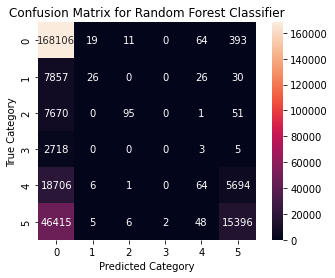

Accuracy of the testing data: 0.6718175101858692
Recall of the testing data: 0.6718175101858692
Precision of the testing data: 0.6718175101858692
F-1 Score of the testing data: 0.6718175101858692


In [ ]:
hashtag_model = cuRFC(n_estimators=200, 
                      split_criterion = 'gini', 
                      n_bins=1024, 
                      max_depth=16, 
                      max_features=1.0)

hashtag_model.fit(X_train_lsi_hashtag, y_train)

pred_test = hashtag_model.predict(X_test_lsi_hashtag)

#confusion matrix
plt_confusion_matrix(y_test, pred_test, 'Random Forest Classifier')

#accuracy, recall, precision, F-1 Score
arpf(y_test, pred_test)

- Random Forest Classifier using Stemming

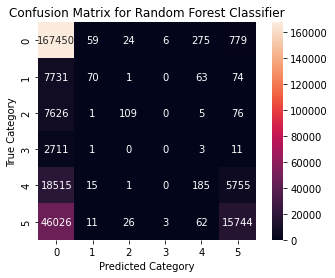

Accuracy of the testing data: 0.6713457051108559
Recall of the testing data: 0.6713457051108559
Precision of the testing data: 0.6713457051108559
F-1 Score of the testing data: 0.6713457051108559


In [ ]:
hashtag_model = cuRFC(n_estimators=200, 
                      split_criterion = 'gini', 
                      n_bins=1024, 
                      max_depth=16, 
                      max_features=1.0)

hashtag_model.fit(X_train_lsi_hashtag, y_train)

pred_test = hashtag_model.predict(X_test_lsi_hashtag)

#confusion matrix
plt_confusion_matrix(y_test, pred_test, 'Random Forest Classifier')

#accuracy, recall, precision, F-1 Score
arpf(y_test, pred_test)

- SVM Classifier using Lemmatization

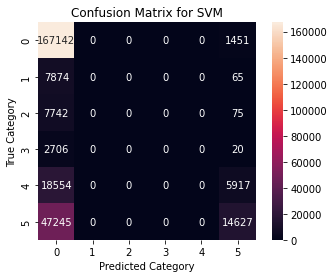

Accuracy of the testing data: 0.6648026099232677
Recall of the testing data: 0.6648026099232677
Precision of the testing data: 0.6648026099232677
F-1 Score of the testing data: 0.6648026099232677


In [ ]:
clf = SVC(kernel='linear', C=0.1, max_iter=10000)
clf.fit(X_train_lsi_hashtag, y_train)

pred_test = clf.predict(X_test_lsi_hashtag)

#confusion matrix
plt_confusion_matrix(y_test, pred_test, 'SVM')

#accuracy, recall, precision, F-1 Score
arpf(y_test, pred_test)

Conclusion:
- Lemmatization vs. Stemming: We can see that there is no much difference on the performance. In the next parts, we will all use lemmatization.
- Random Forest Classifier vs. SVM Classifier: Both are higher than our baseline. And, RFC is doing a little bit better.

# Predict the number of Retweets

- In the next regression prediction parts, since the units of RMSE and MAE in each prediction are different. We will focus on r-squared score to be our baseline. The data we want to predict varies and some features may not have much correlation. So, the general baseline we decide: r-squared score >= 0.25

- Adding normalized features of likes_count, quotes_count, time_count, and two kinds of followers_count 

In [ ]:
def rmse_mae(y_test, pred_test):
    print("RMSE of the testing data: ", math.sqrt(mean_squared_error(y_test, pred_test)))
    print("MAE of the testing data: ", mean_absolute_error(y_test, pred_test))
    print("r-squared score of the testing data: ", r2_score(y_test, pred_test)) 

In [ ]:
# Normalize the data which will be used as features in the latter parts of prediction
y_retweet_train_norm = y_retweet_train / np.linalg.norm(y_retweet_train)
y_retweet_test_norm = y_retweet_test / np.linalg.norm(y_retweet_test)

y_like_train_norm = y_like_train / np.linalg.norm(y_like_train)
y_like_test_norm = y_like_test / np.linalg.norm(y_like_test)

y_quote_train_norm = y_quote_train / np.linalg.norm(y_quote_train)
y_quote_test_norm = y_quote_test / np.linalg.norm(y_quote_test)

y_time_train_norm = y_time_train / np.linalg.norm(y_time_train)
y_time_test_norm = y_time_test / np.linalg.norm(y_time_test)

follower_1_train_norm = follower_1_train / np.linalg.norm(follower_1_train)
follower_1_test_norm = follower_1_test / np.linalg.norm(follower_1_test)

follower_2_train_norm = follower_2_train / np.linalg.norm(follower_2_train)
follower_2_test_norm = follower_2_test / np.linalg.norm(follower_2_test)

In [ ]:
# Adding the useful features
X_train_lsi_retweet = X_train_lsi
X_test_lsi_retweet = X_test_lsi

X_train_lsi_retweet = np.concatenate((X_train_lsi_retweet, y_like_train_norm.reshape(y_like_train_norm.shape[0], 1)), axis=1)
X_test_lsi_retweet = np.concatenate((X_test_lsi_retweet, y_like_test_norm.reshape(y_like_test_norm.shape[0], 1)), axis=1)

X_train_lsi_retweet = np.concatenate((X_train_lsi_retweet, y_quote_train_norm.reshape(y_quote_train_norm.shape[0], 1)), axis=1)
X_test_lsi_retweet = np.concatenate((X_test_lsi_retweet, y_quote_test_norm.reshape(y_quote_test_norm.shape[0], 1)), axis=1)

X_train_lsi_retweet = np.concatenate((X_train_lsi_retweet, y_time_train_norm.reshape(y_time_train_norm.shape[0], 1)), axis=1)
X_test_lsi_retweet = np.concatenate((X_test_lsi_retweet, y_time_test_norm.reshape(y_time_test_norm.shape[0], 1)), axis=1)

X_train_lsi_retweet = np.concatenate((X_train_lsi_retweet, follower_1_train_norm.reshape(follower_1_train_norm.shape[0], 1)), axis=1)
X_test_lsi_retweet = np.concatenate((X_test_lsi_retweet, follower_1_test_norm.reshape(follower_1_test_norm.shape[0], 1)), axis=1)

X_train_lsi_retweet = np.concatenate((X_train_lsi_retweet, follower_2_train_norm.reshape(follower_2_train_norm.shape[0], 1)), axis=1)
X_test_lsi_retweet = np.concatenate((X_test_lsi_retweet, follower_2_test_norm.reshape(follower_2_test_norm.shape[0], 1)), axis=1)

In [ ]:
RMSE = []
MAE = []
r2 = []

- Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = 'svd')

reg = lr.fit(X_train_lsi_retweet, y_retweet_train)

reg_pred_test = reg.predict(X_test_lsi_retweet)
rmse_mae(y_retweet_test, reg_pred_test)

RMSE of the testing data:  5.644783864767152
MAE of the testing data:  0.11503527150080936
r-squared score of the testing data:  0.6546839532194542


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_retweet_test, reg_pred_test)))
MAE.append(float(mean_absolute_error(y_retweet_test, reg_pred_test)))
r2.append(r2_score(y_retweet_test, reg_pred_test))

- Random Forest Regressor

In [ ]:
retweet_model = cuRFR(n_estimators=200,
                      split_criterion='mse',
                      n_bins=1024,
                      max_features=1.0,
                      accuracy_metric='r2')

retweet_model.fit(X_train_lsi_retweet, y_retweet_train)

retweet_pred_test = retweet_model.predict(X_test_lsi_retweet)

In [ ]:
rmse_mae(y_retweet_test, retweet_pred_test)
#print("r-squared score of the training data: ", retweet_model.score(X_train_lsi_retweet, y_retweet_train))

RMSE of the testing data:  7.602861512660419
MAE of the testing data:  0.10957864989728443
r-squared score of the testing data:  0.3735646103965934


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_retweet_test, retweet_pred_test)))
MAE.append(float(mean_absolute_error(y_retweet_test, retweet_pred_test)))
r2.append(r2_score(y_retweet_test, retweet_pred_test))

- Logistic Regression

In [ ]:
lr = LogisticRegression(penalty='l2', C=10, max_iter=10000, tol=0.0001, solver='qn')
                    
reg2 = lr.fit(X_train_lsi_retweet, y_retweet_train)

reg2_pred_test = reg2.predict(X_test_lsi_retweet)
rmse_mae(y_retweet_test, reg2_pred_test)

RMSE of the testing data:  9.604919875023233
MAE of the testing data:  0.10640484532839828
r-squared score of the testing data:  0.000208091581444525


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_retweet_test, reg2_pred_test)))
MAE.append(float(mean_absolute_error(y_retweet_test, reg2_pred_test)))
r2.append(r2_score(y_retweet_test, reg2_pred_test))

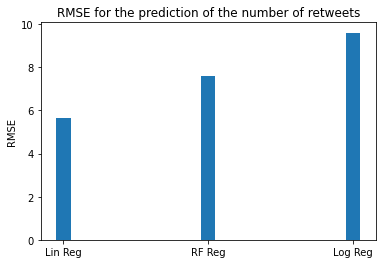

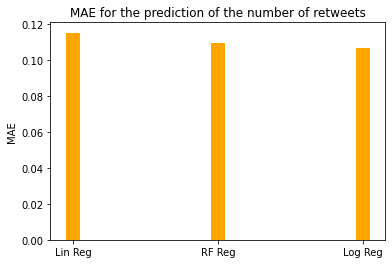

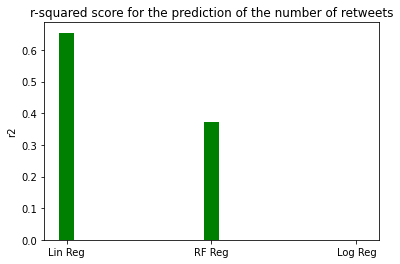

In [ ]:
width = 0.1
xticks = ['Lin Reg', 'RF Reg', 'Log Reg']

plt.bar(xticks, RMSE, width)
plt.ylabel('RMSE')
plt.title('RMSE for the prediction of the number of retweets')
plt.show()

plt.bar(xticks, MAE, width, color='orange')
plt.ylabel('MAE')
plt.title('MAE for the prediction of the number of retweets')
plt.show()

plt.bar(xticks, r2, width, color='green')
plt.ylabel('r2')
plt.title('r-squared score for the prediction of the number of retweets')
plt.show()

Conclusion:
- Linear vs. Random Forest vs. Logistic: We can see that Linear Regression does the best in this task.  The r-squared score of Linear Regression is good. In the next parts, we will only consider use Linear Regression and Random Forest Regression.
- The unit of RMSE is the number of retweets. We think these numbers we get are reasonable since for RMSE, the number has been squared and it will make the error increase significantly.

# Predict the number of Likes

- Adding normalized features of retweetd_count, quotes_count, time_count, and two kinds of followers_count 

In [ ]:
# Adding the useful features
X_train_lsi_like = X_train_lsi
X_test_lsi_like = X_test_lsi

X_train_lsi_like = np.concatenate((X_train_lsi_like, y_retweet_train_norm.reshape(y_retweet_train_norm.shape[0], 1)), axis=1)
X_test_lsi_like = np.concatenate((X_test_lsi_like, y_retweet_test_norm.reshape(y_retweet_test_norm.shape[0], 1)), axis=1)

X_train_lsi_like = np.concatenate((X_train_lsi_like, y_quote_train_norm.reshape(y_quote_train_norm.shape[0], 1)), axis=1)
X_test_lsi_like = np.concatenate((X_test_lsi_like, y_quote_test_norm.reshape(y_quote_test_norm.shape[0], 1)), axis=1)

X_train_lsi_like = np.concatenate((X_train_lsi_like, y_time_train_norm.reshape(y_time_train_norm.shape[0], 1)), axis=1)
X_test_lsi_like = np.concatenate((X_test_lsi_like, y_time_test_norm.reshape(y_time_test_norm.shape[0], 1)), axis=1)

X_train_lsi_like = np.concatenate((X_train_lsi_like, follower_1_train_norm.reshape(follower_1_train_norm.shape[0], 1)), axis=1)
X_test_lsi_like = np.concatenate((X_test_lsi_like, follower_1_test_norm.reshape(follower_1_test_norm.shape[0], 1)), axis=1)

X_train_lsi_like = np.concatenate((X_train_lsi_like, follower_2_train_norm.reshape(follower_2_train_norm.shape[0], 1)), axis=1)
X_test_lsi_like = np.concatenate((X_test_lsi_like, follower_2_test_norm.reshape(follower_2_test_norm.shape[0], 1)), axis=1)

In [ ]:
RMSE = []
MAE = []
r2 = []

- Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = 'svd')

reg = lr.fit(X_train_lsi_like, y_like_train)

reg_pred_test = reg.predict(X_test_lsi_like)
rmse_mae(y_like_test, reg_pred_test)

RMSE of the testing data:  8.26305575002017
MAE of the testing data:  0.17662692014483053
r-squared score of the testing data:  0.4077727536915532


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_like_test, reg_pred_test)))
MAE.append(float(mean_absolute_error(y_like_test, reg_pred_test)))
r2.append(r2_score(y_like_test, reg_pred_test))

- Random Forest Regressor

In [ ]:
like_model = cuRFR(n_estimators=200,
                   split_criterion='mse',
                   n_bins=1024,
                   max_features=1.0,
                   accuracy_metric='r2')

like_model.fit(X_train_lsi_like, y_like_train)

like_pred_test = like_model.predict(X_test_lsi_like)

In [ ]:
rmse_mae(y_like_test, like_pred_test)
# print("r-squared score of the training data: ", like_model.score(X_train_lsi_like, y_like_train))

RMSE of the testing data:  13.123886703124283
MAE of the testing data:  0.14682242981601903
r-squared score of the testing data:  -0.493935897986453


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_like_test, like_pred_test)))
MAE.append(float(mean_absolute_error(y_like_test, like_pred_test)))
r2.append(r2_score(y_like_test, like_pred_test))

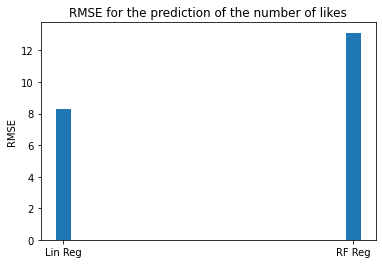

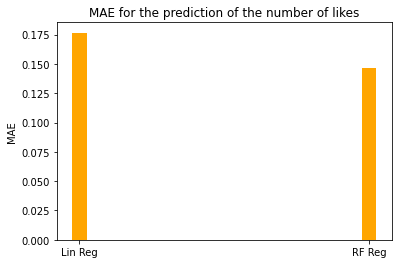

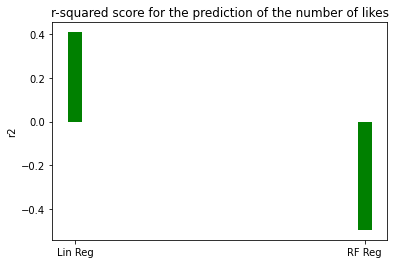

In [ ]:
width = 0.05
xticks = ['Lin Reg', 'RF Reg']

plt.bar(xticks, RMSE, width)
plt.ylabel('RMSE')
plt.title('RMSE for the prediction of the number of likes')
plt.show()

plt.bar(xticks, MAE, width, color='orange')
plt.ylabel('MAE')
plt.title('MAE for the prediction of the number of likes')
plt.show()

plt.bar(xticks, r2, width, color='green')
plt.ylabel('r2')
plt.title('r-squared score for the prediction of the number of likes')
plt.show()

Conclusion:
- Linear vs. Random Forest: We can see that Linear Regression does better in this task. The r-squared score of Linear Regression is relatively good.
- The unit of RMSE is the number of likes. We think these numbers we get are reasonable since for RMSE, the number has been squared and it will make the error increase significantly.

# Predict the number of Quotes

- Adding normalized features of retweets_count, likes_count, time_count, and two kinds of followers_count 

In [ ]:
# Adding the useful features
X_train_lsi_quote = X_train_lsi
X_test_lsi_quote = X_test_lsi

X_train_lsi_quote = np.concatenate((X_train_lsi_quote, y_retweet_train_norm.reshape(y_retweet_train_norm.shape[0], 1)), axis=1)
X_test_lsi_quote = np.concatenate((X_test_lsi_quote, y_retweet_test_norm.reshape(y_retweet_test_norm.shape[0], 1)), axis=1)

X_train_lsi_quote = np.concatenate((X_train_lsi_quote, y_like_train_norm.reshape(y_like_train_norm.shape[0], 1)), axis=1)
X_test_lsi_quote = np.concatenate((X_test_lsi_quote, y_like_test_norm.reshape(y_like_test_norm.shape[0], 1)), axis=1)

X_train_lsi_quote = np.concatenate((X_train_lsi_quote, y_time_train_norm.reshape(y_time_train_norm.shape[0], 1)), axis=1)
X_test_lsi_quote = np.concatenate((X_test_lsi_quote, y_time_test_norm.reshape(y_time_test_norm.shape[0], 1)), axis=1)

X_train_lsi_quote = np.concatenate((X_train_lsi_quote, follower_1_train_norm.reshape(follower_1_train_norm.shape[0], 1)), axis=1)
X_test_lsi_quote = np.concatenate((X_test_lsi_quote, follower_1_test_norm.reshape(follower_1_test_norm.shape[0], 1)), axis=1)

X_train_lsi_quote = np.concatenate((X_train_lsi_quote, follower_2_train_norm.reshape(follower_2_train_norm.shape[0], 1)), axis=1)
X_test_lsi_quote = np.concatenate((X_test_lsi_quote, follower_2_test_norm.reshape(follower_2_test_norm.shape[0], 1)), axis=1)

In [ ]:
RMSE = []
MAE = []
r2 = []

- Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = 'svd')

reg = lr.fit(X_train_lsi_quote, y_quote_train)

reg_pred_test = reg.predict(X_test_lsi_quote)
rmse_mae(y_quote_test, reg_pred_test)

RMSE of the testing data:  27.32441702985442
MAE of the testing data:  1.5213741040916045
r-squared score of the testing data:  0.589646935819709


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_quote_test, reg_pred_test)))
MAE.append(float(mean_absolute_error(y_quote_test, reg_pred_test)))
r2.append(r2_score(y_quote_test, reg_pred_test))

- Random Forest Regressor

In [ ]:
quote_model = cuRFR(n_estimators=200,
                    split_criterion='mse',
                    n_bins=1024,
                    max_features=1.0,
                    accuracy_metric='r2')

quote_model.fit(X_train_lsi_quote, y_quote_train)

quote_pred_test = quote_model.predict(X_test_lsi_quote)

In [ ]:
rmse_mae(y_quote_test, quote_pred_test)
# print("r-squared score of the training data: ", quote_model.score(X_train_lsi_quote, y_quote_train))

RMSE of the testing data:  46.80687848253037
MAE of the testing data:  2.4308691499758477
r-squared score of the testing data:  -0.20413513683569362


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_quote_test, quote_pred_test)))
MAE.append(float(mean_absolute_error(y_quote_test, quote_pred_test)))
r2.append(r2_score(y_quote_test, quote_pred_test))

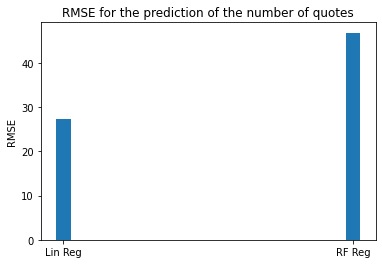

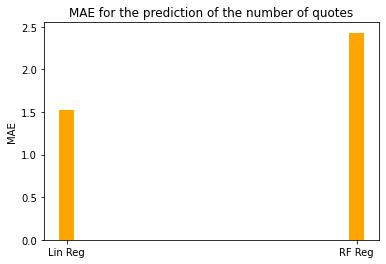

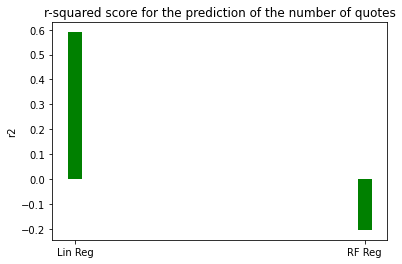

In [ ]:
width = 0.05
xticks = ['Lin Reg', 'RF Reg']

plt.bar(xticks, RMSE, width)
plt.ylabel('RMSE')
plt.title('RMSE for the prediction of the number of quotes')
plt.show()

plt.bar(xticks, MAE, width, color='orange')
plt.ylabel('MAE')
plt.title('MAE for the prediction of the number of quotes')
plt.show()

plt.bar(xticks, r2, width, color='green')
plt.ylabel('r2')
plt.title('r-squared score for the prediction of the number of quotes')
plt.show()

Conclusion:
- Linear vs. Random Forest: We can see that Linear Regression does better in this task. The r-squared score of Linear Regression is good.
- The unit of RMSE is the number of quotes. We think these numbers we get are reasonable since for RMSE, the number has been squared and it will make the error increase significantly.

# Predict the relative(UNIX) time when a tweet was posted

- Adding normalized features of retweets_count, likes_count, quotes_count, and two kinds of followers_count 

In [ ]:
# Adding the useful features
X_train_lsi_time = X_train_lsi
X_test_lsi_time = X_test_lsi

X_train_lsi_time = np.concatenate((X_train_lsi_time, y_retweet_train_norm.reshape(y_retweet_train_norm.shape[0], 1)), axis=1)
X_test_lsi_time = np.concatenate((X_test_lsi_time, y_retweet_test_norm.reshape(y_retweet_test_norm.shape[0], 1)), axis=1)

X_train_lsi_time = np.concatenate((X_train_lsi_time, y_like_train_norm.reshape(y_like_train_norm.shape[0], 1)), axis=1)
X_test_lsi_time = np.concatenate((X_test_lsi_time, y_like_test_norm.reshape(y_like_test_norm.shape[0], 1)), axis=1)

X_train_lsi_time = np.concatenate((X_train_lsi_time, y_quote_train_norm.reshape(y_quote_train_norm.shape[0], 1)), axis=1)
X_test_lsi_time = np.concatenate((X_test_lsi_time, y_quote_test_norm.reshape(y_quote_test_norm.shape[0], 1)), axis=1)

X_train_lsi_time = np.concatenate((X_train_lsi_time, follower_1_train_norm.reshape(follower_1_train_norm.shape[0], 1)), axis=1)
X_test_lsi_time = np.concatenate((X_test_lsi_time, follower_1_test_norm.reshape(follower_1_test_norm.shape[0], 1)), axis=1)

X_train_lsi_time = np.concatenate((X_train_lsi_time, follower_2_train_norm.reshape(follower_2_train_norm.shape[0], 1)), axis=1)
X_test_lsi_time = np.concatenate((X_test_lsi_time, follower_2_test_norm.reshape(follower_2_test_norm.shape[0], 1)), axis=1)

In [ ]:
RMSE = []
MAE = []
r2 = []

- Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = 'svd')

reg = lr.fit(X_train_lsi_time, y_time_train)

reg_pred_test = reg.predict(X_test_lsi_time)
rmse_mae(y_time_test, reg_pred_test)

RMSE of the testing data:  4355.861641044072
MAE of the testing data:  3585.0382982385895
r-squared score of the testing data:  0.13610066565181378


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_time_test, reg_pred_test)))
MAE.append(float(mean_absolute_error(y_time_test, reg_pred_test)))
r2.append(r2_score(y_time_test, reg_pred_test))

- Random Forest Regressor

In [ ]:
time_model = cuRFR(n_estimators=200,
                   split_criterion='mse',
                   n_bins=1024,
                   max_features=1.0,
                   max_depth=256, 
                   accuracy_metric='r2')

time_model.fit(X_train_lsi_time, y_time_train)

time_pred_test = time_model.predict(X_test_lsi_time)

In [ ]:
rmse_mae(y_time_test, time_pred_test)
print("r-squared score of the training data: ", time_model.score(X_train_lsi_time, y_time_train))

RMSE of the testing data:  3949.7112764462186
MAE of the testing data:  2972.6146395761853
r-squared score of the testing data:  0.2896936678305433
r-squared score of the training data:  0.7881966093588663


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(y_time_test, time_pred_test)))
MAE.append(float(mean_absolute_error(y_time_test, time_pred_test)))
r2.append(r2_score(y_time_test, time_pred_test))

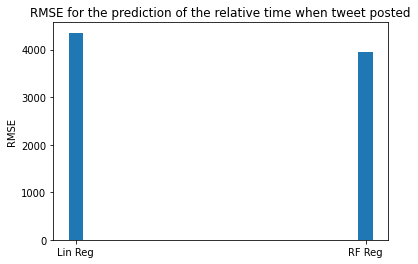

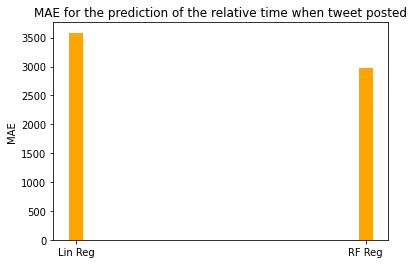

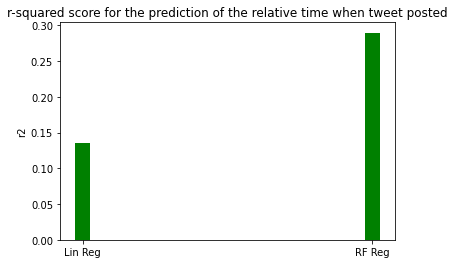

In [ ]:
width = 0.05
xticks = ['Lin Reg', 'RF Reg']

plt.bar(xticks, RMSE, width)
plt.ylabel('RMSE')
plt.title('RMSE for the prediction of the relative time when tweet posted')
plt.show()

plt.bar(xticks, MAE, width, color='orange')
plt.ylabel('MAE')
plt.title('MAE for the prediction of the relative time when tweet posted')
plt.show()

plt.bar(xticks, r2, width, color='green')
plt.ylabel('r2')
plt.title('r-squared score for the prediction of the relative time when tweet posted')
plt.show()

Conclusion:
- Linear vs. Random Forest: We can see that Random Forest Regression does better in this task.
- The units of RMSE and MAE are seconds. We think these numbers we get are reasonable since the timing distributes broadly and we use five-hour data.
- Compared to MAE, the number of RMSE has been squared and it will make the error increase significantly, especially the unit is second in this task.

# Creativity - Predict the number of followers of the person tweeting

- Adding normalized features of retweets_count, likes_count, quotes_count, and time_count

In [ ]:
# Adding the useful features
X_train_lsi_follower = X_train_lsi
X_test_lsi_follower = X_test_lsi

X_train_lsi_follower = np.concatenate((X_train_lsi_follower, y_retweet_train_norm.reshape(y_retweet_train_norm.shape[0], 1)), axis=1)
X_test_lsi_follower = np.concatenate((X_test_lsi_follower, y_retweet_test_norm.reshape(y_retweet_test_norm.shape[0], 1)), axis=1)

X_train_lsi_follower = np.concatenate((X_train_lsi_follower, y_like_train_norm.reshape(y_like_train_norm.shape[0], 1)), axis=1)
X_test_lsi_follower = np.concatenate((X_test_lsi_follower, y_like_test_norm.reshape(y_like_test_norm.shape[0], 1)), axis=1)

X_train_lsi_follower = np.concatenate((X_train_lsi_follower, y_quote_train_norm.reshape(y_quote_train_norm.shape[0], 1)), axis=1)
X_test_lsi_follower = np.concatenate((X_test_lsi_follower, y_quote_test_norm.reshape(y_quote_test_norm.shape[0], 1)), axis=1)

X_train_lsi_follower = np.concatenate((X_train_lsi_follower, y_time_train_norm.reshape(y_time_train_norm.shape[0], 1)), axis=1)
X_test_lsi_follower = np.concatenate((X_test_lsi_follower, y_time_test_norm.reshape(y_time_test_norm.shape[0], 1)), axis=1)

In [ ]:
RMSE = []
MAE = []
r2 = []

- Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = 'svd')

reg = lr.fit(X_train_lsi_follower, follower_1_train)

reg_pred_test = reg.predict(X_test_lsi_follower)
rmse_mae(follower_1_test, reg_pred_test)

RMSE of the testing data:  68744.36962092745
MAE of the testing data:  3395.827596530905
r-squared score of the testing data:  0.73726706888122


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(follower_1_test, reg_pred_test)))
MAE.append(float(mean_absolute_error(follower_1_test, reg_pred_test)))
r2.append(r2_score(follower_1_test, reg_pred_test))

- Random Forest Regressor

In [ ]:
follower_model = cuRFR(n_estimators=200,
                   split_criterion='mse',
                   n_bins=1024,
                   max_features=1.0,
                   accuracy_metric='r2')

follower_model.fit(X_train_lsi_follower, follower_1_train)

follower_pred_test = follower_model.predict(X_test_lsi_follower)

In [ ]:
rmse_mae(follower_1_test, follower_pred_test)
# print("r-squared score of the training data: ", follower_model.score(X_train_lsi_follower, follower_1_train))

RMSE of the testing data:  83164.44330403922
MAE of the testing data:  2748.714073029891
r-squared score of the testing data:  0.6154829403507002


In [ ]:
RMSE.append(math.sqrt(mean_squared_error(follower_1_test, follower_pred_test)))
MAE.append(float(mean_absolute_error(follower_1_test, follower_pred_test)))
r2.append(r2_score(follower_1_test, follower_pred_test))

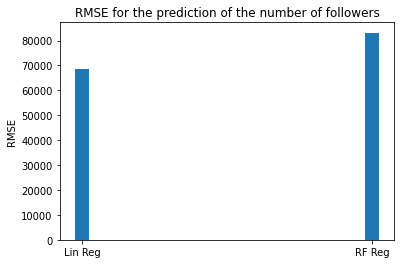

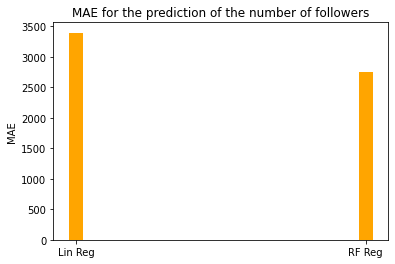

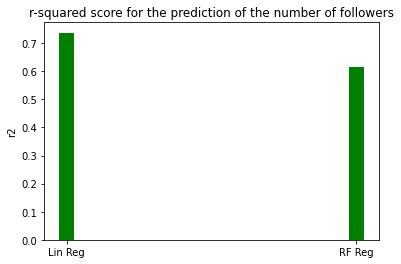

In [ ]:
width = 0.05
xticks = ['Lin Reg', 'RF Reg']

plt.bar(xticks, RMSE, width)
plt.ylabel('RMSE')
plt.title('RMSE for the prediction of the number of followers')
plt.show()

plt.bar(xticks, MAE, width, color='orange')
plt.ylabel('MAE')
plt.title('MAE for the prediction of the number of followers')
plt.show()

plt.bar(xticks, r2, width, color='green')
plt.ylabel('r2')
plt.title('r-squared score for the prediction of the number of followers')
plt.show()

Conclusion:
- Linear vs. Random Forest: We can see that both Linear Regression and Random Forest Regression do great in this task. Linear Regression is a little bit better since the r-squared score of Linear Regression is higher.
- The units of RMSE and MAE are the number of followers. We think these numbers we get are reasonable since the numbers of followers are usually very high and varies, e.g. 0.1K ~ 100K.
- For RMSE, the number has been squared and it will make the error increase more significantly than MAE.